In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from beamforming import construct_slowness_grid, construct_times_beamforming, precompute_A, CMTM, noise_space_projection


## Data generation

In [2]:
# Parameters
nch = 100  # number of receivers
fs = 100.0  # sampling rate
nt = 1024  # number of samples
freq_band = (1.0, 2.0)  # must be a narrow range, but not too narrow...

# Generate random receiver locations
RNG = np.random.default_rng(42)
x, y = RNG.uniform(-10, 10, size=(2, nch))

# Generate random data
data = RNG.normal(size=(nch, nt))

""" Select frequency band """
nfft = 2 ** int(np.log2(nt) + 1) + 1  # Don't mess with this...
freqs = scipy.fft.rfftfreq(n=2 * nfft, d=1 / fs)
inds = (freqs >= freq_band[0]) & (freqs < freq_band[1])
freqs_select = freqs[inds]


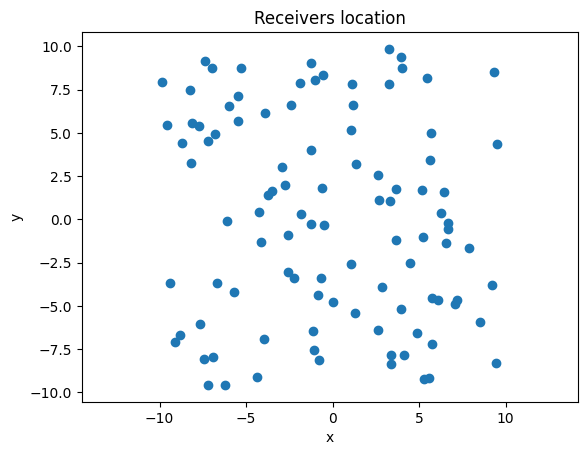

In [3]:
plt.scatter(x, y)
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Receivers location");

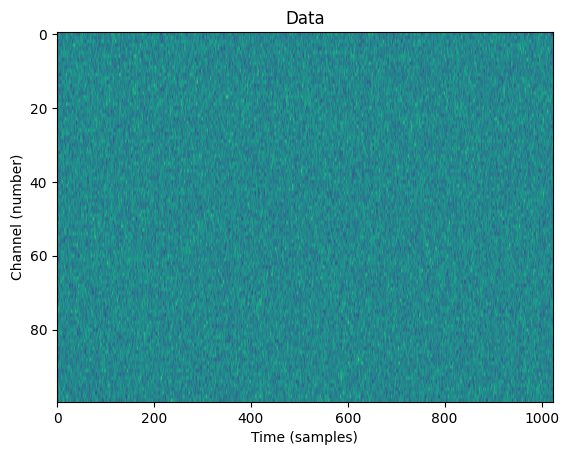

In [4]:
plt.imshow(data, aspect="auto")
plt.xlabel("Time (samples)")
plt.ylabel("Channel (number)")
plt.title("Data");

## Initialize beamformer

In [5]:
# Parameters
ntheta, nslow = 90, 30  # resolution of the slowness grid
vmin, vmax = 500, 10_000  # velocity range of slowness grid
theta = np.linspace(0, 2 * np.pi, ntheta)  # azimuthal range of slowness grid

# Slowness in x/y, and velocity grid
Sx, Sy, v_grid = construct_slowness_grid(theta, vmin, vmax, nslow)
Sx = Sx.ravel().reshape((1, -1))
Sy = Sy.ravel().reshape((1, -1))

# Differential times
dt = construct_times_beamforming(x, y, Sx, Sy)

# Steering vectors
A = precompute_A(dt, freqs_select)


## Beamform data

In [6]:
# Compute covariance matrix
nw = 3  # Number of tapers
Cxy = CMTM(data, Nw=nw, freq_band=freq_band, fsamp=fs)

# Compute beampower
Pr = noise_space_projection(Cxy, A, sources=1)
P = 1.0 / Pr
P = P.reshape((ntheta, nslow))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Plot results

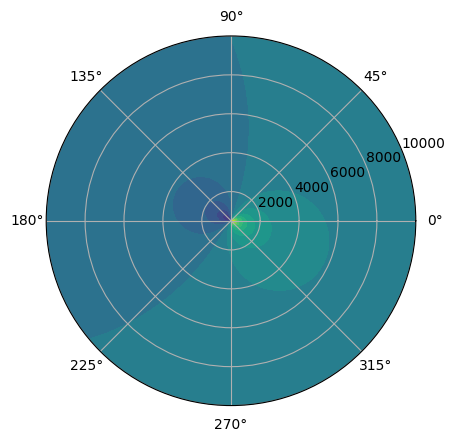

In [7]:
fig, ax = plt.subplots(
   subplot_kw={"projection": "polar"}
)
CS = ax.contourf(
    theta, v_grid, P.T, cmap="viridis", levels=20
)